# TP4
Por Mariano Parada <BR>
DS-33  -  2020<BR>
[Github](https://github.com/marianoparada/DataScience)


### Aclaraciones previas:
Este trabajo es complementario al TP3, por lo que se sugiere verlo antes [AQUÍ](https://github.com/marianoparada/DataScience/blob/main/PLN%20con%20reviews%20de%20Amazon.ipynb)

Adicionalmente va acompañado con una presentación ejecutiva para la presentación del objetivo, la problemática, las alternativas y sus conclusiones.
en donde se presentan desde una perspectiva visual y amigable tanto el problema como las propuestas

Para agilizar el proceso se tomó una muestra del 15%  (si se quisiera ver el universo, cambiar el valor de la variable muestra)

In [ ]:
# ! pip install sentiment-analysis-spanish

### Cargamos las librerías

In [2]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')
stemmer = PorterStemmer()
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
lemmatizer = WordNetLemmatizer()
# Guardamos las stopwords en español en una variable
stopwords = nltk.corpus.stopwords.words('english')
stop_words = stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mariano\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mariano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mariano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mariano\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Definimos la función google_trans_new
Que nos permitirá traducir el texto de cada reseña de español al inglés

In [3]:
#import random
#esp = ingles.cuerpo[random.choice(ingles.index)]
from google_trans_new import google_translator  

def traduce_en(txt):
    #traducimos al inglés
    from google_trans_new import google_translator  
    t = google_translator(url_suffix="ar", timeout=10)
    translate_text = t.translate(txt, "en")
    #print (translate_text)
    return translate_text

### Carrgamos nuestro Dataset y lo unimos en [data]

In [4]:
import pandas as pd
dev=pd.read_json(r'C:\Users\Mariano\Desktop\Acamica\TP3\NLP\dataset_es_dev.json', lines=True)
test=pd.read_json(r'C:\Users\Mariano\Desktop\Acamica\TP3\NLP\dataset_es_test.json', lines=True)
train=pd.read_json(r'C:\Users\Mariano\Desktop\Acamica\TP3\NLP\dataset_es_train.json', lines=True)

In [5]:
data = pd.concat([dev,test,train], axis=0)

### Sacamos una muestra aleatoria

In [299]:
#Sacamos una muestra aleatoria. En muestra se debe poner el porcentaje a considerar.
#Dada la cantidad de registros estadísticamente la muestra nos dá métricas confiables por arriba del 10% 
muestra=15
experiment_size = int(len(data.index)*muestra/100)
completerandom_idx = data.sample(int(experiment_size),random_state = 42).index
data = data.loc[completerandom_idx,:]
data.shape

(121, 38)

### Traducimos la reseña y el título

In [9]:
%%time
data['review_body'] = data['review_body'].map(traduce_en)

Wall time: 3h 31min 22s


In [10]:
%%time
data['review_title'] = data['review_title'].map(traduce_en)

Wall time: 3h 18min 58s


### Corroboramos que se haya traducido el texto

In [11]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
184949,es_0551312,product_es_0105367,reviewer_es_0461939,5,Ideal flavor and texture! I loved it! I used t...,Healthy and delicious,es,grocery
151875,es_0332711,product_es_0776227,reviewer_es_0439865,4,"The case serves its purpose, and turns off the...",It complies.,es,other
51912,es_0068313,product_es_0152017,reviewer_es_0900700,2,I have changed it for another model from anoth...,Sound quality hardly improves,es,other
25966,es_0388948,product_es_0022550,reviewer_es_0646185,1,"I imagined something else more like a baby, a ...",Came quickly,es,toy
133596,es_0683703,product_es_0795198,reviewer_es_0618807,4,If what you want is a box to store just enough...,Tool box.,es,home_improvement


# Creacion de características:
1. Vamos a crear el promedio de calificacion para cada categoría de producto.<br>
2. Vamos a unir el título y la reseña en un campo "cuerpo".<br>

In [12]:
data['promprod'] = data.groupby(['product_category'])['stars'].transform('mean')
data['cuerpo'] = data[['review_title', 'review_body']].apply(' . '.join, axis=1)

In [13]:
# Vamos a eliminar algunas columnas que no vamos a utilizar:
data.drop(['review_id','product_id','reviewer_id','language'], axis = 'columns', inplace=True)

# Analisis de sentimiento con VADER

![ChessUrl](https://i.imgur.com/pvorT.gif "DarkSide")

### Vamos a utilizar la función polarity_scores de NLTK VADER
La misma asigna un valor negativo, positivo, neutro y un compuesto para un texto para ver si logramos una correlación entre algunos de estos valores y las calificaciones otorgadas. Previamente el texto fue traducido gracias a la librería google_translate_new del español al inglés.

In [14]:
%%time
data["neg"] = data["cuerpo"].apply(lambda x:sia.polarity_scores(x)["neg"])
data["pos"] = data["cuerpo"].apply(lambda x:sia.polarity_scores(x)["pos"])
data["neu"] = data["cuerpo"].apply(lambda x:sia.polarity_scores(x)["neu"])
data["compuesto"] = data["cuerpo"].apply(lambda x:sia.polarity_scores(x)["compound"])

Wall time: 1min 1s


In [16]:
### Aplicamos TextBlob para polaridad y subjetividad
from textblob import TextBlob

# Agregamos dos analisis más: polaridad y subjetividad con la librería: TextBlob

![ChessUrl](https://miro.medium.com/proxy/1*_JW1JaMpK_fVGld8pd1_JQ.gif "sentimiento")

In [17]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [18]:
data['subjectivity'] = data['cuerpo'].map(getSubjectivity)

In [19]:
data['polarity'] = data['cuerpo'].map(getPolarity)

In [20]:
data.head(1)

,stars,review_body,review_title,product_category,promprod,cuerpo,neg,pos,neu,compuesto,subjectivity,polarity
184949,5,Ideal flavor and texture! I loved it! I used t...,Healthy and delicious,grocery,3.010753,Healthy and delicious . Ideal flavor and text...,0.052,0.428,0.520,0.9421,0.800000,0.679167
151875,4,"The case serves its purpose, and turns off the...",It complies.,other,2.990113,"It complies. . The case serves its purpose, a...",0.000,0.066,0.934,0.2960,0.375000,0.083333
51912,2,I have changed it for another model from anoth...,Sound quality hardly improves,other,2.990113,Sound quality hardly improves . I have change...,0.065,0.142,0.793,0.7665,0.476919,0.061263
25966,1,"I imagined something else more like a baby, a ...",Came quickly,toy,2.959902,Came quickly . I imagined something else more...,0.206,0.205,0.588,-0.0036,0.562500,-0.026042
133596,4,If what you want is a box to store just enough...,Tool box.,home_improvement,2.906381,Tool box. . If what you want is a box to stor...,0.000,0.248,0.752,0.7845,0.700000,0.566667


### Armando un panda con los sentimientos y guardando lo realizado en dos CSV
El proceso de análisis de sentimiento tomo en total aproximadamente 12 horas por lo que vamos a guardar nuestro dataset para tener un nuevo punto de partida y agilizar el proceso.


In [21]:
### Ahora realizaremos promedio para cada calificacion de 1 a 5 , para cada característica: largo, neg, pos, neu y compuesto
polar = data[["stars", "neg","pos","neu","compuesto","subjectivity","polarity"]]

In [22]:
data.to_csv('data.csv', index = False)
polar.to_csv('polar.csv', index = False)

In [201]:
data = pd.read_csv('data.csv',encoding = 'utf-8')
data = pd.DataFrame(data)

polar = pd.read_csv('polar.csv',encoding = 'utf-8')
polar =pd.DataFrame(polar)

In [202]:
data.stars = data.stars.astype(np.int)
polar.stars = polar.stars.astype(np.int)

### Veamos como se correlacionan los sentimientos y la variable de respuesta: STARS 

In [203]:
import seaborn as sns
polar.corr()

,stars,neg,pos,neu,compuesto,subjectivity,polarity
stars,1.000000,-0.477085,0.636727,-0.373102,0.674803,0.307700,0.624584
neg,-0.477085,1.000000,-0.437189,-0.196353,-0.737192,-0.050493,-0.541572
pos,0.636727,-0.437189,1.000000,-0.796017,0.734037,0.401459,0.680363
neu,-0.373102,-0.196353,-0.796017,1.000000,-0.304140,-0.403695,-0.377276
compuesto,0.674803,-0.737192,0.734037,-0.304140,1.000000,0.266092,0.690468
subjectivity,0.307700,-0.050493,0.401459,-0.403695,0.266092,1.000000,0.320398
polarity,0.624584,-0.541572,0.680363,-0.377276,0.690468,0.320398,1.000000


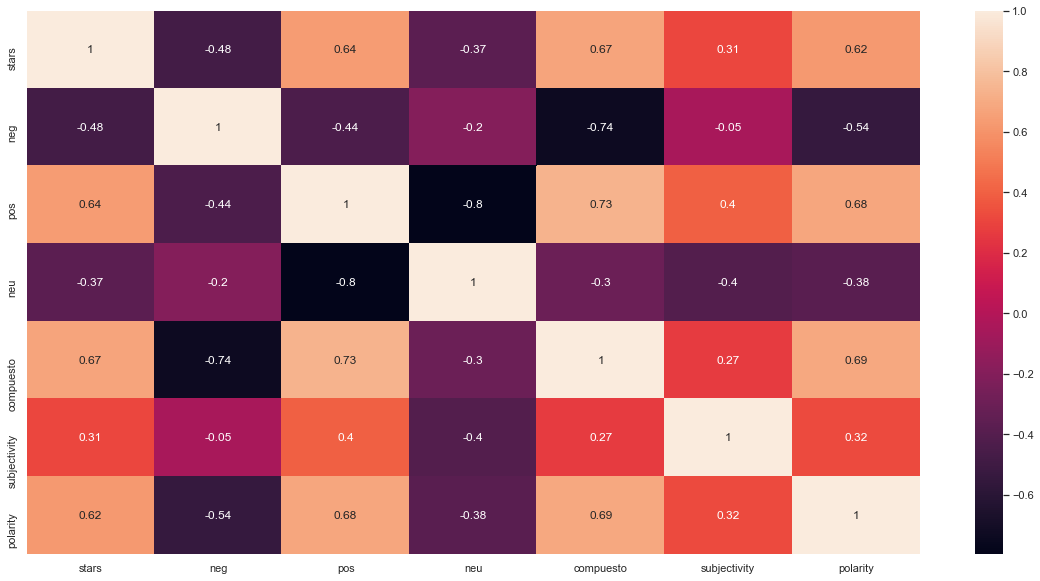

In [204]:
plt.figure(figsize=(20,10))
sns.set_theme(palette='bright')
sns.heatmap(polar.corr(), annot = True, fmt='.2g',robust='true')

### Visualizando los promedios de sentimiento para cada calificación :
Para esto, haremos gráficos polares o "spider charts" los cuales nos permitirán ver mucha información en un solo golpe de vista, en este caso, cada uno de los sentimientos analizados, para cada calificación:

In [206]:
negativos=[]
for i in range (1,6):
    neg=polar[polar.stars == i].neg.mean()
    negativos.append(neg)

positivos=[]
for i in range (1,6):
    posi=polar[polar.stars == i].pos.mean()
    positivos.append(posi)

neutros=[]
for i in range (1,6):
    neut=polar[polar.stars == i].neu.mean()
    neutros.append(neut)
    
compuesto=[]
for i in range (1,6):
    comp=(polar[polar.stars == i].compuesto.mean() +1)/2
    compuesto.append(comp)

polarity=[]
for i in range (1,6):
    pol=(polar[polar.stars == i].polarity.mean() +1)/2
    polarity.append(pol)

subjetivity=[]
for i in range (1,6):
    sub=polar[polar.stars == i].subjectivity.mean()
    subjetivity.append(sub)
#compuesto = (compuesto + 1) / 2
#polarity = (polarity + 1) / 2

print("Promedios negativos por calificación: ", negativos)
print("Promedios positivos por calificación: ",positivos)
print("Promedios neutros por calificación: ",neutros)
print("Promedios compuestos por calificación: ",compuesto)
print("Promedios de polaridad por calificación: ",polarity)
print("Promedios de subjetividad por calificación: ",subjetivity)

Promedios negativos por calificación:  [0.15328660212740539, 0.11996987863722779, 0.070300949598247, 0.03380117968637606, 0.01861688311688311]
Promedios positivos por calificación:  [0.05278917174614548, 0.0851087878344788, 0.1556655953250546, 0.2750435908502369, 0.34810173160173236]
Promedios neutros por calificación:  [0.7939183697860618, 0.7949279134376382, 0.7740283418553693, 0.6911591137965747, 0.6332842712842687]
Promedios compuestos por calificación:  [0.34545539619935417, 0.4510346688112298, 0.6205176771365956, 0.7949932024169171, 0.8704729220779215]
Promedios de polaridad por calificación:  [0.45196584458560746, 0.5087976688041395, 0.5819288141718019, 0.6762268590438135, 0.7386999274763503]
Promedios de subjetividad por calificación:  [0.443898225759999, 0.4866957644027572, 0.5179415062896371, 0.579519105816847, 0.640920520769429]


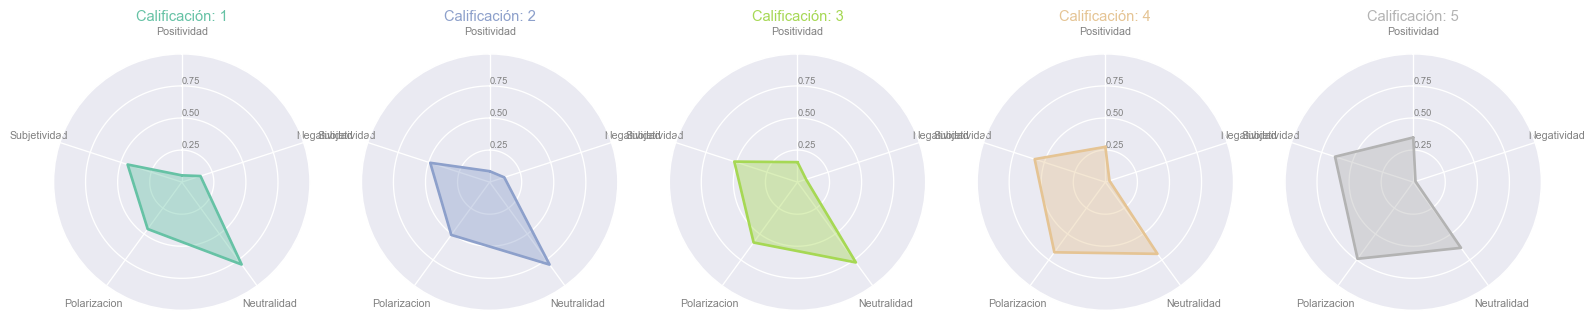

In [276]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# Set data
df = pd.DataFrame({
'group': ['1','2','3','4','5'],
'Positividad': positivos,
'Negatividad': negativos,
'Neutralidad': neutros,
'Polarizacion': polarity,
'Subjetividad': subjetivity,
})
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
def make_spider( row, title, color):
    # number of variable
    categories=list(df)[1:]
    N = len(categories)
 
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(1,5,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25,0.50,0.75], ["0.25","0.50","0.75"], color="grey", size=7)
    plt.ylim(0,1)
 
    # Ind1
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(20,8), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, 5):
    make_spider( row=row, title='Calificación: '+df['group'][row], color=my_palette(row))

# Y si vemos todos juntos para intentar encontrar algún patrón ?

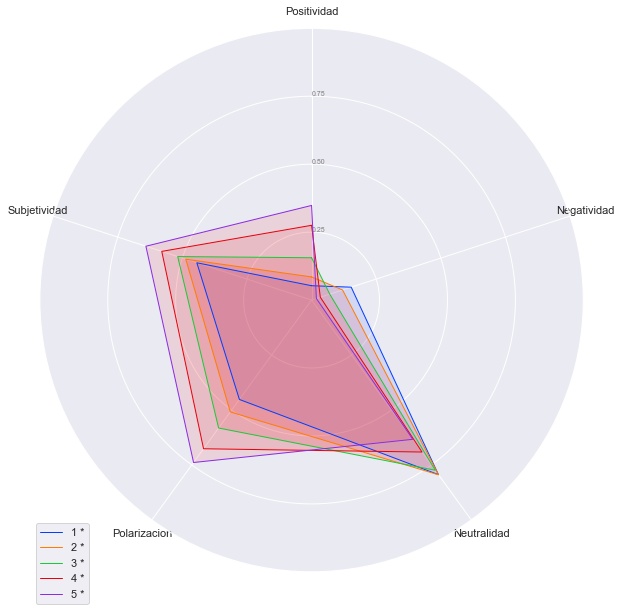

In [277]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
plt.figure(figsize=(20,10)) 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.50,0.75], ["0.25","0.50","0.75"], color="grey", size=7)
plt.ylim(0,1) 
 
# ------- PART 2: Add plots
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# 1*
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="1 *")
ax.fill(angles, values, 'b', alpha=0.1)
 
# 2*
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="2 *")
ax.fill(angles, values, 'r', alpha=0.1)

# 3*
values=df.loc[2].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="3 *")
ax.fill(angles, values, 'r', alpha=0.1)
 
# 4*
values=df.loc[3].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="4 *")
ax.fill(angles, values, 'r', alpha=0.1)

# 5*
values=df.loc[4].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="5 *")
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Análisis:
Como se puede apreciar el análisis de sentimiento promedio es consecuente con el sentido común. El mas negativo es 1*, y el más positivo es 5*. A su vez subjetividad y polaridad tambien se encuentran escalonadamente representados de 1 a 5 *. Más adelante utilizaremos _feature_importances_ de Random Forest para poder ver si esto tuvo impacto o no en nuestro modelo ...

### Preprocesamiento ...
Guardamos "product_category" y transformamos la categoría en columnas con get_dummies()<BR>
Esta transformación nos permitirá incorporar la variable categórica a nuestro modelo.

In [209]:
data['producto'] = data['product_category']
# Aplicamos get_dummies:
data = pd.get_dummies (data, columns = ['product_category'])

# Preprocesamiento del texto
Como ya sabemos nuestros algoritmos solo entienden números, por lo que debemos de alguna forma transpolar las características e incidencias de nuestras palabras, oraciones y calificaciones de manera numérica.<BR>
Para esto, utilizaremos algunas funciones para quitar caracteres extraños, pasar todo a minúsculas, consolidar palabras por su raíz o lema, y finalmente armar vectores de palabras para poder medir su frecuencia.<BR>
Con todo esto finalmente agregaremos columnas de las palabras con mayor frecuencia y utilizaremos algo similar al "one hot encoding" pero representando la frecuencia de cada una de ellas.


In [210]:
%%time
# Vamos a limpiar el dataset y armamos dos listas, una con todos los reviews positivos y otro con los negativos:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

titular_list=[]
for titular in data.cuerpo:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras
    titular=nltk.word_tokenize(titular)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    titular = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in titular]
    #frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in titular]
    
    # Eliminamos las palabras d emenos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    #dataset["titular_normalizado"] = titular_list
    titular_list.append(titular)

Wall time: 16min 58s


In [211]:
data["cuerpo"] = titular_list

### Generemos una lista para luego vectorizar: 

In [212]:
cuerpo = list(data['cuerpo'].values)
stars = data['stars'].values

In [213]:
from sklearn.feature_extraction.text import CountVectorizer
# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000
# Es decir que cada instancia tendrá max_features features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)
matriz_cuerpo = cou_vec.fit_transform(titular_list)
# Tomamos las palabras
all_words = cou_vec.get_feature_names()

In [214]:
import re
import string

### Raices más utilizadas ordenadas por frecuencia:

In [215]:
frecuencias = re.sub("[^a-zA-Z]"," ",str(titular_list))
words = frecuencias.split()
table = str.maketrans('', '', string.punctuation)
frecuencias = [w.translate(table) for w in words]
frecuencias= nltk.FreqDist(frecuencias)
#frecuencia de palabras del cuerpo de reseñas
frecuencias = pd.DataFrame(frecuencias.items(),columns=['word','Frequency'])
# ordenar por frecuencia
frecuencias.sort_values('Frequency',inplace=True,ascending=False)
frecuencias.head(10)


,word,Frequency
70,good,13664
40,well,7472
28,quality,7436
106,product,6287
39,work,5280
7,like,4916
176,price,4634
53,come,4126
21,time,3684
59,little,3427


Seguimos vectorizando

In [216]:
#visualización de mi vector
vector=matriz_cuerpo.toarray()
header=sorted(cou_vec.vocabulary_.keys())
df_palabras = pd.DataFrame(vector,columns=header)

In [217]:
backup = data
data = data.drop(columns=["cuerpo","producto","review_body","review_title"])#,"tokens","stemm"])
data.reset_index(inplace=True, drop=True)
df_palabras.reset_index(inplace=True, drop=True)
panda = pd.concat([data, df_palabras], axis=1)


In [218]:
tp4=backup

### Definimos xtrain, xtest, ytrain, ytest con train_test_split y una función para graficar la matriz de confusión

In [219]:
x = panda.drop(columns=["stars"])
y = panda.stars
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [220]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["1","2","3","4","5"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

# Modelando
### Benchmark: Veamos la exactitud con Naive Bayes
Si bien el modelo benchmark más elemental es del 20% (surge de evaluar la probabilidad que tengo al azar de acertar una calificación 1/5) utilizaremos Naive Bayes como modelo base ya que esperamos que supere ese 20%

In [221]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("Exactitud Naive Bayes (Gaussian): ",nb.score(xtrain,ytrain))

Exactitud Naive Bayes (Gaussian):  0.44024332061068705


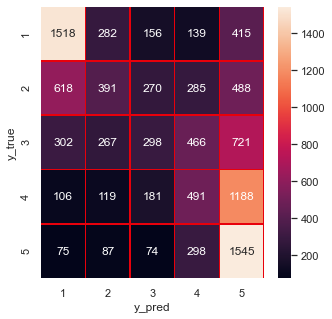

In [222]:
y_pred_nb=nb.predict(xtest)
confusion(ytest,y_pred_nb)

In [223]:
from sklearn.metrics import confusion_matrix, classification_report
report=pd.DataFrame(classification_report(ytest, y_pred_nb, output_dict=True)).transpose() #otra manera de hacer
print("Reporte de Clasificación Naive Bayes:")
report

Reporte de Clasificación Naive Bayes:


,precision,recall,f1-score,support
1,0.579611,0.604781,0.591928,2510.000000
2,0.341187,0.190546,0.244528,2052.000000
3,0.304392,0.145083,0.196505,2054.000000
4,0.292436,0.235492,0.260893,2085.000000
5,0.354602,0.743146,0.480112,2079.000000
accuracy,0.393599,0.393599,0.393599,0.393599
macro avg,0.374445,0.383809,0.354793,10780.000000
weighted avg,0.382848,0.393599,0.364865,10780.000000


Se visualiza una muy buena predicción en los polos (1 y 5) y va disminuyendo a medida que se acerca al centro. Tomando estos resultados y si se replican a lo largo de los modelos, quizás convenga aceptar la propuesta de convertir el problema en binario es decir, si califican a un producto de bueno o malo.

### Ahora veamos con Random Forest: 

In [224]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 10, random_state=42)
rf.fit(xtrain,ytrain)
print("Exactitud Random Forest: ",rf.score(xtrain,ytrain))

Exactitud Random Forest:  0.9862833969465649


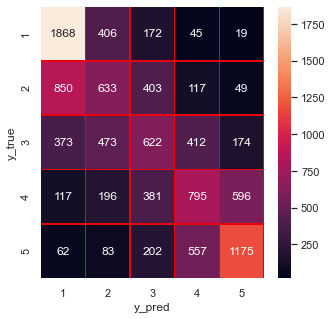

In [225]:
y_pred_rf=rf.predict(xtest)
confusion(ytest,y_pred_rf)

In [226]:
from sklearn.metrics import confusion_matrix, classification_report
report=pd.DataFrame(classification_report(ytest, y_pred_rf, output_dict=True)).transpose() #otra manera de hacer
print("Reporte de Clasificación Random Forest:")
report

Reporte de Clasificación Random Forest:


,precision,recall,f1-score,support
1,0.571254,0.744223,0.646367,2510.000000
2,0.353434,0.308480,0.329430,2052.000000
3,0.349438,0.302824,0.324465,2054.000000
4,0.412773,0.381295,0.396410,2085.000000
5,0.583706,0.565176,0.574291,2079.000000
accuracy,0.472449,0.472449,0.472449,0.472449
macro avg,0.454121,0.460399,0.454193,10780.000000
weighted avg,0.459276,0.472449,0.462457,10780.000000


### Utilizamos la función feature_importances_ de RF para ver que esta utilizando el modelo para predecir

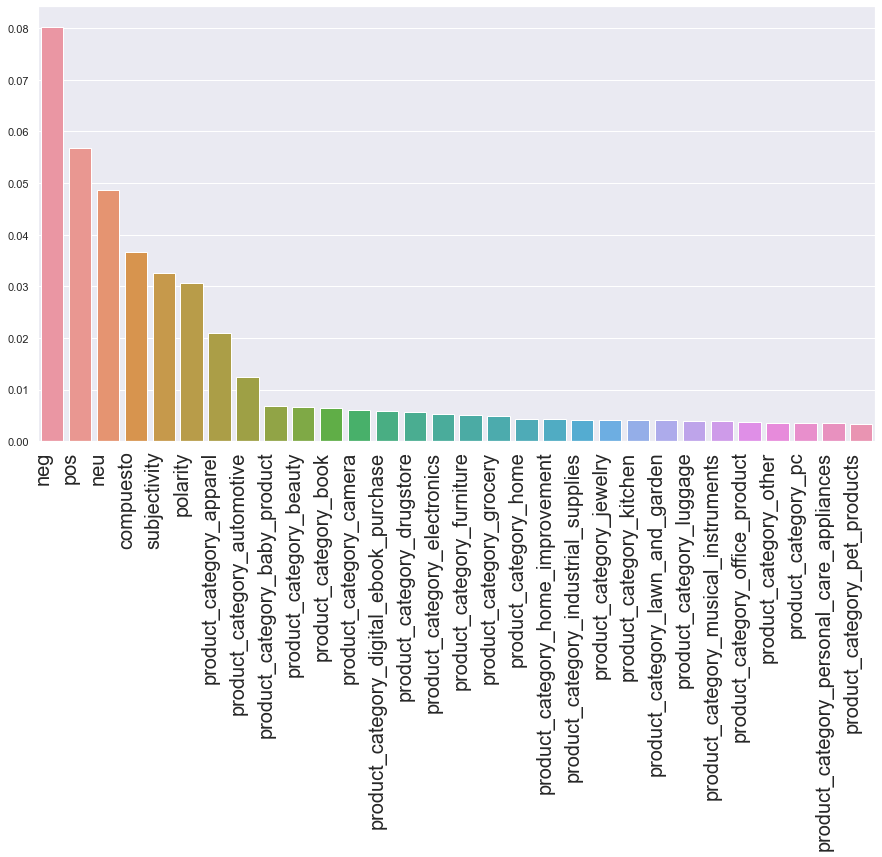

In [283]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = x.columns

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:30]
selected_columns = [columns[i] for i in range(0,30)]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
plt.xticks(rotation=90 , ha='right', fontsize=20)
sns.barplot(selected_columns, selected_importances)
plt.savefig('importantes.png',bbox_inches='tight',transparent=True,pad_inches=0.1)
plt.show()

### Podrá un algoritmo de soporte de vectores identificar mejor a las clases ? veamos ...

In [231]:
# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# Para el Kernel Lineal, esta función es MUCHO mas rapida que la tradicional SVC.
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
print("Exactitud SVM- Linear SVC: ",svc.score(xtrain,ytrain))

Exactitud SVM- Linear SVC:  0.5773695928753181


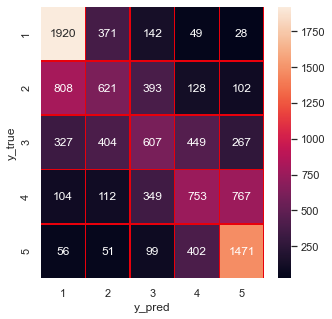

In [232]:
y_pred_svm=svc.predict(xtest)
confusion(ytest,y_pred_svm)

In [233]:
from sklearn.metrics import confusion_matrix, classification_report
report=pd.DataFrame(classification_report(ytest, y_pred_svm, output_dict=True)).transpose() #otra manera de hacer
print("Reporte de Clasificación SVM con SVC:")
report

Reporte de Clasificación SVM con SVC:


,precision,recall,f1-score,support
1,0.597201,0.764940,0.670742,2510.00000
2,0.398332,0.302632,0.343949,2052.00000
3,0.381761,0.295521,0.333150,2054.00000
4,0.422796,0.361151,0.389550,2085.00000
5,0.558254,0.707552,0.624098,2079.00000
accuracy,0.498330,0.498330,0.498330,0.49833
macro avg,0.471669,0.486359,0.472298,10780.00000
weighted avg,0.477053,0.498330,0.480830,10780.00000


# Optimización de modelos e hiperparámetros

In [234]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [235]:
%%time
#Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
#max_depth.append(None)
#min_samples_split = [1, 2, 5,10]
#min_samples_leaf = [1, 2,4,8]
#bootstrap = [True, False]# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
#rf = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 150, cv = 5, verbose=2, random_state=21, n_jobs = -1)# Fit the random search model
#rf_random.fit(xtrain, ytrain)

Wall time: 0 ns


Una vez obtenidos los hiperparámetros correctos, comentamos la celda completa ya que el proceso demoró 14 horas.

In [236]:
#mejores_parametros = rf_random.best_params_
#mejores_parametros

### Guardamos los mejores parámetros para no volver a correr RandomizedSearchCV

In [237]:
mejores_parametros = {
    'n_estimators' : 1200,
    'min_samples_split' : 2,
    'min_samples_leaf' : 1,
    'max_features' : 'sqrt',
    'max_depth' : 46,
    'bootstrap' : 'False'
}

In [238]:
%%time
RFR = RandomForestClassifier(**mejores_parametros)
RFR.fit(xtrain, ytrain)

Wall time: 7min 47s


RandomForestClassifier(bootstrap='False', max_depth=46, max_features='sqrt',
                       n_estimators=1200)

In [239]:
%%time
print("Exactitud Random Forest con optimización HP: ",RFR.score(xtrain,ytrain))

Exactitud Random Forest con optimización HP:  0.9727258269720102
Wall time: 19.7 s


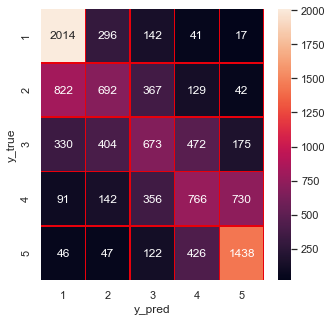

In [240]:
y_pred_rf=RFR.predict(xtest)
confusion(ytest,y_pred_rf)

In [241]:
from sklearn.metrics import confusion_matrix, classification_report
report=pd.DataFrame(classification_report(ytest, y_pred_rf, output_dict=True)).transpose() #otra manera de hacer
print("Reporte de Clasificación RF optimizando hiperparámetros:")
report

Reporte de Clasificación RF optimizando hiperparámetros:


,precision,recall,f1-score,support
1,0.609749,0.802390,0.692930,2510.000000
2,0.437698,0.337232,0.380952,2052.000000
3,0.405422,0.327653,0.362412,2054.000000
4,0.417666,0.367386,0.390916,2085.000000
5,0.598668,0.691679,0.641821,2079.000000
accuracy,0.517904,0.517904,0.517904,0.517904
macro avg,0.493840,0.505268,0.493806,10780.000000
weighted avg,0.498778,0.517904,0.502298,10780.000000


### Limpiamos un poco el texto que nos quedo para medir frecuencias de palabras:

# Veamos si existen diferencias entre las palabras más utilizadas en las calificaciones positivas y negativas:
Para esto arbitrariamente decidí tomar 1 y 2 como calificaciones negativas , 4 y 5 como positivas y 3 como neutra por lo que queda fuera del análisis.

In [243]:
backup = backup.filter(['stars','cuerpo'], axis=1)
df_positivas = backup[backup.stars>=4]
df_negativas = backup[backup.stars<=2]

Confirmemos que el slice y subset hayan funcionado para ambos datasets:

In [244]:
df_positivas.head(1)

,stars,cuerpo
0,5,healthy delicious ideal flavor texture love ha...


In [245]:
df_negativas.head(1)

,stars,cuerpo
2,2,sound quality hardly improves change another m...


In [246]:
positivas = str(list(df_positivas['cuerpo'].values))
words = positivas.split()
table = str.maketrans('', '', string.punctuation)
positivas = [w.translate(table) for w in words]
freq_positivas= nltk.FreqDist(positivas)
freq_positivas

FreqDist({'good': 9041, 'quality': 3297, 'well': 3277, 'perfect': 2787, 'price': 2589, 'product': 2376, 'great': 1961, 'like': 1870, 'work': 1604, 'recommend': 1503, ...})

In [247]:
negativas = str(list(df_negativas['cuerpo'].values))
words = negativas.split()
table = str.maketrans('', '', string.punctuation)
negativas = [w.translate(table) for w in words]
freq_negativas= nltk.FreqDist(negativas)
freq_negativas

FreqDist({'product': 3033, 'quality': 2817, 'work': 2789, 'well': 2564, 'come': 2256, 'return': 2202, 'like': 2134, 'good': 2029, 'arrive': 1988, 'time': 1734, ...})

### Palabras positivas por frecuencia:

In [248]:
#frecuencia de palabras del cuerpo de reseñas
data_positivos = pd.DataFrame(freq_positivas.items(),columns=['word','Frequency'])
# ordenar por frecuencia
data_positivos.sort_values('Frequency',inplace=True,ascending=False)
data_positivos.head(5)

,word,Frequency
37,good,9041
35,quality,3297
77,well,3277
34,perfect,2787
80,price,2589


### Palabras negativas según su frecuencia:

In [249]:
#frecuencia de palabras del cuerpo de reseñas
data_negativas = pd.DataFrame(freq_negativas.items(),columns=['word','Frequency'])
# ordenar por frecuencia
data_negativas.sort_values('Frequency',inplace=True,ascending=False)
data_negativas.head(5)

,word,Frequency
35,product,3033
1,quality,2817
12,work,2789
13,well,2564
26,come,2256


### Vamos a visualizar en un gráfico las palabras positivas y negativas por frecuencia:

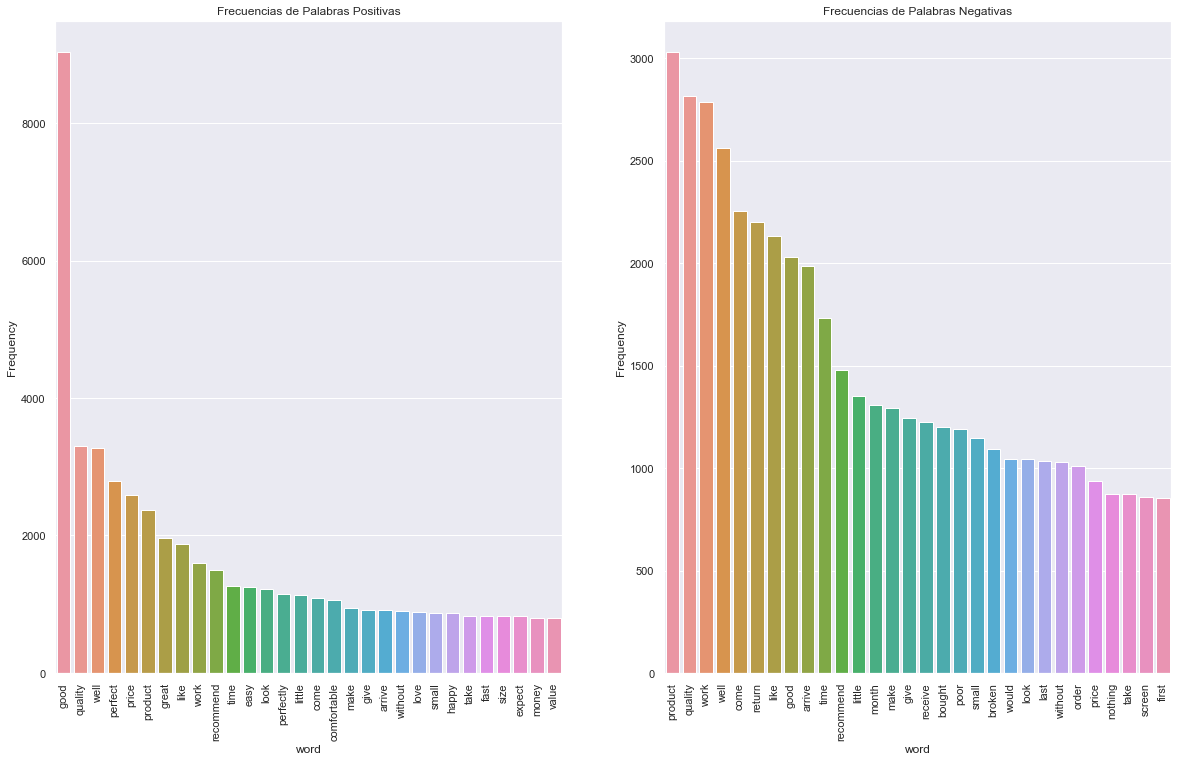

In [250]:
plt.figure(figsize = (20,12))
plt.subplot(1,2,1)
sns.barplot(x=data_positivos.iloc[:30].word,
            y=data_positivos.iloc[:30].Frequency )

plt.xticks(rotation=90)
plt.title("Frecuencias de Palabras Positivas")

plt.subplot(1,2,2)
sns.barplot(x=data_negativas.iloc[:30].word,
            y=data_negativas.iloc[:30].Frequency)

plt.xticks(rotation=90)
plt.title("Frecuencias de Palabras Negativas")
plt.show()

In [251]:
positivas = str(positivas)
negativas = str(negativas)

# Propuesta I - Convertir el problema en binario ?
Claramente Sí, ya que como vimos en las matrices de confusión los modelos pierden exactitud a medida que se acercan a una calificación media (2,3 y 4). Para esto, convertiremos las calificaciones en negativas (valores 1 y 2) representado con un 0, y positivas (valores 3,4 y 5) representados con un 1. y correremos rápido un algoritmo que funcionó bastante bien y es mucho más ágil que RF: SVM-SVC

In [253]:
backup.head()

,stars,cuerpo
0,5,healthy delicious ideal flavor texture love ha...
1,4,complies case serf purpose turn screen cover k...
2,2,sound quality hardly improves change another m...
3,1,come quickly imagine something else like baby ...
4,4,tool want store enough walk around house perfe...


In [254]:
backup = panda
backup.stars = backup.stars.replace({1: 0,2: 0,3: 1,4: 1,5: 1})

In [255]:
x = backup.drop(columns=["stars"])
y = backup.stars
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [271]:
# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# Para el Kernel Lineal, esta función es MUCHO mas rapida que la tradicional SVC.
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)
print("Exactitud Problema binario con SVM-SVC: ",svc.score(xtrain,ytrain))

Exactitud Problema binario con SVM-SVC:  0.8552798982188295


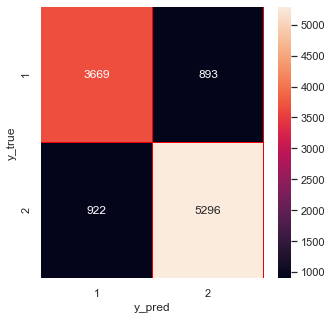

In [272]:
y_pred_svm=svc.predict(xtest)
confusion(ytest,y_pred_svm)

In [273]:
from sklearn.metrics import confusion_matrix, classification_report
report=pd.DataFrame(classification_report(ytest, y_pred_svm, output_dict=True)).transpose() #otra manera de hacer
print("Reporte de Clasificación BINARIA con SVM Linear SVC:")
report

Reporte de Clasificación BINARIA con SVM Linear SVC:


,precision,recall,f1-score,support
0,0.799172,0.804253,0.801704,4562.000000
1,0.855712,0.851721,0.853712,6218.000000
accuracy,0.831633,0.831633,0.831633,0.831633
macro avg,0.827442,0.827987,0.827708,10780.000000
weighted avg,0.831785,0.831633,0.831703,10780.000000


# Conclusiones TP4 :
  
El objetivo de este trabajo fue definir la conveniencia o no de traducir textos al inglés para utilizar las librerías de análisis de sentimiento tradicionales y mas difundidas como vader y textblob.

Tal como se muestra en la presentación que complementa a este trabajo, La exactitud para algunos modelos mejoró y para otros no, por lo que deberíamos analizar para cada proyecto en particular la conveniencia o no de hacer el proceso de traducción.

Yo sugeriría mejorar el modelo de negocio aplicando esta idea dentro del siguiente Workflow:

1. Un usuario escribe una reseña (previo a otorgar la calificación)
2. El sitio analiza el sentimiento (por binario) el cual puede ser negativo o positivo.

3. Si es NEGATIVO le ofrecemos hablar por chat donde un CHATBOT identificará si el problema es asimilable al producto o si el usuario no sabe utilizarlo.
 
 Si es del producto intentaremos fidelizarlo ofreciéndole descuentos para productos similares (recordemos que no esta conforme con su compra).
 Si es del usuario le daremos prioridad para chatear con un especialista de esa categoría de productos.
 Una vez finalizado el proceso le ofreceremos cambiar la reseña y calificar.
 
 
4. Si es POSITIVO, agradeceremos el feedback y lo llevaremos a la página para calificar.
 
 
Por lo anteriormente expuesto, ambas opciones tienen aspectos positivos y negativos que deberán ser evaluados según el objetivo del proyecto, por ejemplo:

Realizar análisis de sentimiento con un texto en español tiene comom ventajas que intervienen menos librerías por lo que el proceso será mas ágil y tendremos  menos puntos de falla (en este sentido a veces un usuario que responde una encuesta o entra a otorgar una reseña exige instantaneidad). Sin embargo la exactitud fue algo menor para los modelos de RANDOM Forest con optimización de hiperparámetros y SVM-SVC.

Por otro lado, el utilizar una librería para traducir las reseñas convierte a mi modelo en multilenguaje ya que solo modificando el parámetro del lenguaje de origen puedo llegar al de destino (inglés) lo cual amplía considerablemente al público objetivo ya que pudiendo analizar reseñas en distintos idiomas mi modelo gana en diversidad de la muestra con la que entrena lo cual intuyo que podría colaborar en una mejor generalización al predecir.
Asimismo las reseñas traducidas lograron mejorar en 2 y 3 % al modelo del TP3, alcanzando una exactitud de 85% en entrenamiento y 83% en testing.

Como dije anteriormente, encarar este trabajo fue sumamente enriquecedor ya que no solo pude mejorar el resultado del TP3, sino que incorporé las librerías de traducción, análisis de sentimiento con VADER y TextBLOB y la presentación ejecutiva que nos acerca más a como presentar un problema y una solución a un  potencial cliente.


# Y quisiera terminar nuevamente agradeciendote tu tiempo y deseandote lo mejor para el año que está por comenzar. Felicidades ! 

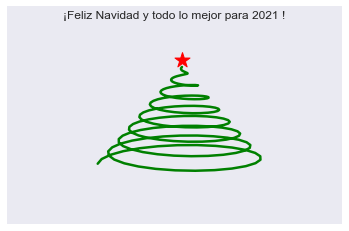

In [293]:

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Calculate spiral coordinates for the Xmas tree
theta = np.linspace(-8 * np.pi, 8 * np.pi, 200) 
z = np.linspace(-3, 0, 200)
r = 5
x = r * np.sin(theta)*z
y = r * np.cos(theta)*z
 
# Use matplotib and its OOP interface to draw it 
fig = plt.figure() # Create figure
ax = fig.gca(projection='3d') # It's a 3D Xmas tree!
ax.view_init(15, 0) # Set a nice view angle
ax._axis3don = False # Hide the 3d axes
 
# Plot the Xmas tree as a line
ax.plot(x, y, z,
        c='green', linewidth=2.5)
 
# Every Xmas tree needs a star
ax.scatter(0, 0, 0.2,
           c='red', s=250, marker='*')
 
# Type here your best whishes
ax.set_title(u"¡Feliz Navidad y todo lo mejor para 2021 !")
plt.show()

# TP4
Por Mariano Parada <BR>
DS-33  -  2020<BR>
[Github](https://github.com/marianoparada/DataScience)
